In [42]:
import kmapper as km
import sklearn
import json
import networkx as nx
import numpy as np
import scipy
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import cm

### This is for all of the compunds in the data set, which is before applying the mapper

In [2]:
with open('./../Elastic_tensor/tensordata202002/tsrdata20200217_0930est.json', 'r') as fp:
    dat = json.load(fp)

In [8]:
elastic_tsr = [] # tensor
formula = [] # chemical formula
xtal_c = [] # crystal type
K_ls = [] # K list
G_ls = [] # G list
GK_ls = [] # G/K list

for entry in dat:
    if 0 < entry['elasticity']['K_Reuss'] < 300:
        if 0 < entry['elasticity']['G_Reuss'] <200:
#         if 0.1 < entry['elasticity']['poisson_ratio'] < 0.45:
            K_ls.append(entry['elasticity']['K_Reuss'])
            G_ls.append(entry['elasticity']['G_Reuss'])
            GK_ls.append(entry['elasticity']['G_Reuss']/entry['elasticity']['K_Reuss'])
#             lens.append(entry['elasticity']['poisson_ratio'])
#             lens.append(np.array([entry['elasticity']['K_VRH'], entry['elasticity']['poisson_ratio']]))
            formula.append(entry['full_formula'])
            elastic_tsr.append(np.array(entry['elasticity']['elastic_tensor']).flatten())
            xtal_c.append(entry['spacegroup.crystal_system'])

In [11]:
# test to make sure type, for division for the pugh's ratio
# type(entry['elasticity']['G_Reuss'])

float

## Choosing the following number of intervals, eps/#interval: G: 25/70,  K: 25/90,   GK: 45/90
## Mapper results are generated in the other notebook

## Filter function: G Shear Modulus

Text(0.5,0.98,'Filter Function: G Shear Modulus')

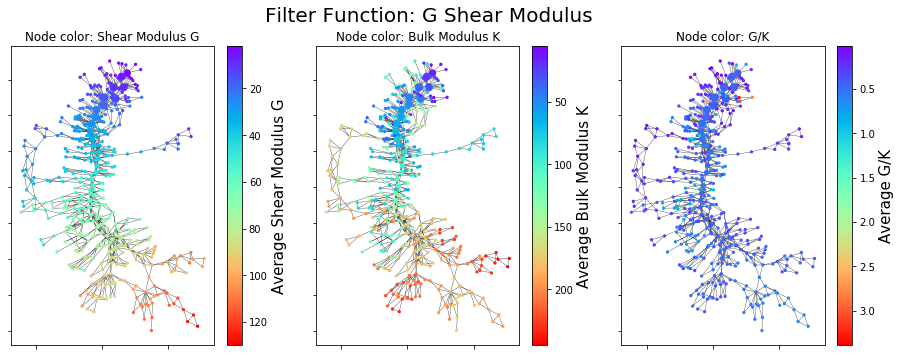

In [96]:
# read simplicial complex
with open('./results/simp_comp1.json', 'r') as fp:
    smp_cmp_dic = json.load(fp)

# set colormap
cm1 = plt.cm.get_cmap('rainbow')
# select number of filter function intervals and the corresponding simp.comp.
n_cub = 70
simplicial_complex = smp_cmp_dic[f'smpcmp_ncub{n_cub}']

# dics to store the values which determine the color of the node for all nodes.
# the color can be G, K and G/K.
node_c_dicK = {}
node_c_dicG = {}
node_c_dicGK = {}
# the crystal types of the compounds in every nodes as well.
node_xtal_dic = {}
# iterate through all nodes
for ii, tt in dict(simplicial_complex["nodes"]).items():
    # average is used
    node_c_dicK[ii] = np.average([K_ls[kk] for kk in tt])
    node_c_dicG[ii] = np.average([G_ls[kk] for kk in tt])
    node_c_dicGK[ii] = np.average([GK_ls[kk] for kk in tt])
    node_xtal_dic[ii] = [xtal_c[kk] for kk in tt]

# nodes and edges     
nodes = simplicial_complex["nodes"].keys()
edges = [[start, end] for start, ends in simplicial_complex["links"].items() for end in ends]
# new graph, with adding nodes and nodes properties.
g = nx.Graph()
g.add_nodes_from(nodes)
nx.set_node_attributes(g, dict(simplicial_complex["nodes"]), "membership")
# setting attributes to nodes
nx.set_node_attributes(g, node_c_dicG, "node_clrG")
nx.set_node_attributes(g, node_c_dicK, "node_clrK")
nx.set_node_attributes(g, node_c_dicGK, "node_clrGK")
# add edges to graph
g.add_edges_from(edges)
# get the largest connected components for plotting.
# This is optional, but if there are more than one connected components
# in the mapper output, the layout can have overlap.
largest_cc = max(nx.connected_components(g), key=len)

# below are the lists/dics for plotting,
# only plot the largest connected component.
nd_plt = [] # list of nodes coordinates
nd_plt_d = {} # dic of nodes coordinates
nd_clr = {'G':[], 'K':[], 'GK':[]} # values of nodes for coloring
edg_ls = [] # edge list for plotting
ndsz_ls = [] # node size, length of the member lists
nd_cmpd_ls = [] # nodes compounds list, store the compounds in every nodes
nd_nbr_ls = [] # nodes neighbors list, store the neighbors of every nodes in the largest c.c.
mktp = ['$\mathrm{C}$', '$\mathrm{O}$', '$\mathrm{T}$'] # markers in scatter plot

# since we only show the largest connected component in the plot,
# need to test if the node is belonging to the largest c.c.
for ed in g.edges:
    if ed[0] in largest_cc or ed[1] in largest_cc:
        edg_ls.append(ed)

nd_cntr_ls = [] # counter for nodes indices
# the nodes from mapper output are indexed as strings,
# need this to convert to number so can be easily read in excel files.
nd_xtal_ls = [] # list for storing crystal systems of the nodes that are in the largest c.c.

# select a layout method
for nd, pos in nx.kamada_kawai_layout(g).items():
# for nd, pos in nx.spring_layout(g).items():
# for nd, pos in nx.spectral_layout(g).items():
    if nd in largest_cc:
        nd_cntr_ls.append(nd) # append the current node to list
        nd_plt.append([pos[0], pos[1]])
        nd_plt_d[nd] = pos
        nd_clr['G'].append(g.nodes[nd]['node_clrG'])
        nd_clr['K'].append(g.nodes[nd]['node_clrK'])
        nd_clr['GK'].append(g.nodes[nd]['node_clrGK'])
        ndsz_ls.append(len(g.nodes[nd]['membership']))
        nd_cmpd_ls.append([formula[jj] for jj in g.nodes[nd]['membership']])
        nd_xtal_ls.append(node_xtal_dic[nd])
for nd in nd_cntr_ls:
    nd_nbr_ls.append([nd_cntr_ls.index(nnbb) for nnbb in g.neighbors(nd)])


        
flt_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
clr_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
# Figure
fig1 = plt.figure(figsize=(15.5,5.5))
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax1 = fig1.add_subplot(1,3,subplt)
    for ed in edg_ls:
        ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
            c='k', linewidth=.3, zorder=1)
    sc = ax1.scatter(*np.array(nd_plt).T, 
                     c=nd_clr[clr_ppt],
                     s= 50*np.array(ndsz_ls)/max(ndsz_ls)+5,
                     zorder=2, edgecolor=None, cmap=cm1)
    cbar = fig1.colorbar(mappable=sc, ax=ax1)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'Average {clr_title[subplt-1]}', fontsize=15)
    ax1.set_title(f'Node color: {clr_title[subplt-1]}')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

# # fig1.suptitle('Filter Function: Bulk Modulus', fontsize=20)
fig1.suptitle('Filter Function: G Shear Modulus', fontsize=20)
# # fig1.suptitle('Filter Function: G/K (Ductility)', fontsize=20)

In [39]:
fig1.savefig('./results/figs/flt_shear_GKGk.png', bbox_ineches='tight', dpi=300)

In [41]:
# len(nd_cmpd_ls)
# save to Excel
pd.DataFrame(nd_cmpd_ls).to_excel('./results/cmp_flt_shearG.xlsx')
pd.DataFrame(nd_nbr_ls).to_excel('./results/nbr_flt_shearG.xlsx')

Text(0.5,0.98,'Filter Function: G Shear Modulus')

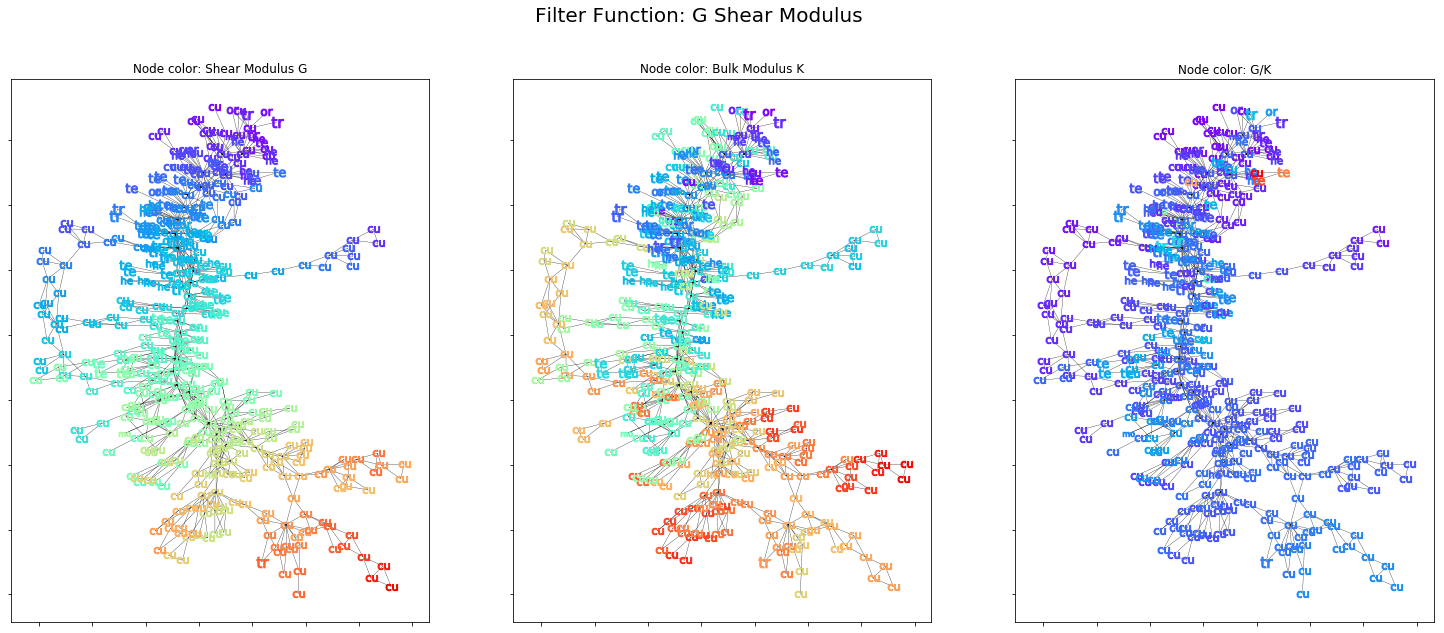

In [97]:
# Figure for xtal systems
cm1 = plt.cm.get_cmap('rainbow')
fig1xtal = plt.figure(figsize=(25.5,10))
ax1 = fig1xtal.add_subplot(1,3,1)
ax2 = fig1xtal.add_subplot(1,3,2)
ax3 = fig1xtal.add_subplot(1,3,3)
axall = [ax1, ax2, ax3]

for ed in edg_ls:
    ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax2.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax3.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax_c = axall[subplt-1]
    for xxyy, cnd_xtal, ndclr in zip(nd_plt, nd_xtal_ls, nd_clr[clr_ppt]):
        xtal_cntr = Counter(cnd_xtal)
        mk_xtal = max(xtal_cntr, key=xtal_cntr.get)
    #     if xtal_cntr.get(mk_xtal) >= len() # use when for at least of half of the materials are the same
                                             # crystal system.
        ax_c.scatter(xxyy[0], xxyy[1], marker= '$\mathrm{'+mk_xtal[:2]+'}$',
                   zorder=2,
                     c = cm1((ndclr-min(nd_clr[clr_ppt]))/(max(nd_clr[clr_ppt])-min(nd_clr[clr_ppt]))),
                     s=150)
    ax_c.set_title(f'Node color: {clr_title[subplt-1]}')
    ax_c.set_xticklabels([])
    ax_c.set_yticklabels([])
fig1xtal.suptitle('Filter Function: G Shear Modulus', fontsize=20)

In [98]:
fig1xtal.savefig('./results/figs/flt_shear_GKGk_xtal.png', bbox_ineches='tight', dpi=300)

## Filter function: K Bulk Modulus

Text(0.5,0.98,'Filter Function: K Bulk Modulus')

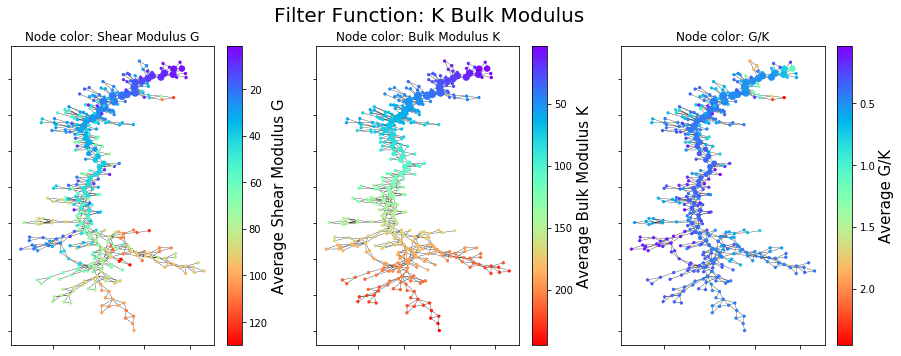

In [99]:
# read simplicial complex
with open('./results/simp_comp2K.json', 'r') as fp:
    smp_cmp_dic = json.load(fp)

# set colormap
cm1 = plt.cm.get_cmap('rainbow')
# select number of filter function intervals and the corresponding simp.comp.
n_cub = 90
simplicial_complex = smp_cmp_dic[f'smpcmp_ncub{n_cub}']

# dics to store the values which determine the color of the node for all nodes.
# the color can be G, K and G/K.
node_c_dicK = {}
node_c_dicG = {}
node_c_dicGK = {}
# the crystal types of the compounds in every nodes as well.
node_xtal_dic = {}
# iterate through all nodes
for ii, tt in dict(simplicial_complex["nodes"]).items():
    # average is used
    node_c_dicK[ii] = np.average([K_ls[kk] for kk in tt])
    node_c_dicG[ii] = np.average([G_ls[kk] for kk in tt])
    node_c_dicGK[ii] = np.average([GK_ls[kk] for kk in tt])
    node_xtal_dic[ii] = [xtal_c[kk] for kk in tt]

# nodes and edges     
nodes = simplicial_complex["nodes"].keys()
edges = [[start, end] for start, ends in simplicial_complex["links"].items() for end in ends]
# new graph, with adding nodes and nodes properties.
g = nx.Graph()
g.add_nodes_from(nodes)
nx.set_node_attributes(g, dict(simplicial_complex["nodes"]), "membership")
# setting attributes to nodes
nx.set_node_attributes(g, node_c_dicG, "node_clrG")
nx.set_node_attributes(g, node_c_dicK, "node_clrK")
nx.set_node_attributes(g, node_c_dicGK, "node_clrGK")
# add edges to graph
g.add_edges_from(edges)
# get the largest connected components for plotting.
# This is optional, but if there are more than one connected components
# in the mapper output, the layout can have overlap.
largest_cc = max(nx.connected_components(g), key=len)

# below are the lists/dics for plotting,
# only plot the largest connected component.
nd_plt = [] # list of nodes coordinates
nd_plt_d = {} # dic of nodes coordinates
nd_clr = {'G':[], 'K':[], 'GK':[]} # values of nodes for coloring
edg_ls = [] # edge list for plotting
ndsz_ls = [] # node size, length of the member lists
nd_cmpd_ls = [] # nodes compounds list, store the compounds in every nodes
nd_nbr_ls = [] # nodes neighbors list, store the neighbors of every nodes in the largest c.c.
mktp = ['$\mathrm{C}$', '$\mathrm{O}$', '$\mathrm{T}$'] # markers in scatter plot

# since we only show the largest connected component in the plot,
# need to test if the node is belonging to the largest c.c.
for ed in g.edges:
    if ed[0] in largest_cc or ed[1] in largest_cc:
        edg_ls.append(ed)

nd_cntr_ls = [] # counter for nodes indices
# the nodes from mapper output are indexed as strings,
# need this to convert to number so can be easily read in excel files.
nd_xtal_ls = [] # list for storing crystal systems of the nodes that are in the largest c.c.

# select a layout method
for nd, pos in nx.kamada_kawai_layout(g).items():
# for nd, pos in nx.spring_layout(g).items():
# for nd, pos in nx.spectral_layout(g).items():
    if nd in largest_cc:
        nd_cntr_ls.append(nd) # append the current node to list
        nd_plt.append([pos[0], pos[1]])
        nd_plt_d[nd] = pos
        nd_clr['G'].append(g.nodes[nd]['node_clrG'])
        nd_clr['K'].append(g.nodes[nd]['node_clrK'])
        nd_clr['GK'].append(g.nodes[nd]['node_clrGK'])
        ndsz_ls.append(len(g.nodes[nd]['membership']))
        nd_cmpd_ls.append([formula[jj] for jj in g.nodes[nd]['membership']])
        nd_xtal_ls.append(node_xtal_dic[nd])
for nd in nd_cntr_ls:
    nd_nbr_ls.append([nd_cntr_ls.index(nnbb) for nnbb in g.neighbors(nd)])


        
flt_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
clr_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
# Figure
fig1 = plt.figure(figsize=(15.5,5.5))
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax1 = fig1.add_subplot(1,3,subplt)
    for ed in edg_ls:
        ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
            c='k', linewidth=.3, zorder=1)
    sc = ax1.scatter(*np.array(nd_plt).T, 
                     c=nd_clr[clr_ppt],
                     s= 50*np.array(ndsz_ls)/max(ndsz_ls)+5,
                     zorder=2, edgecolor=None, cmap=cm1)
    cbar = fig1.colorbar(mappable=sc, ax=ax1)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'Average {clr_title[subplt-1]}', fontsize=15)
    ax1.set_title(f'Node color: {clr_title[subplt-1]}')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

fig1.suptitle('Filter Function: K Bulk Modulus', fontsize=20)
# fig1.suptitle('Filter Function: G Shear Modulus', fontsize=20)
# # fig1.suptitle('Filter Function: G/K (Ductility)', fontsize=20)

In [100]:
fig1.savefig('./results/figs/flt_bulk_GKGk.png', bbox_ineches='tight', dpi=300)

In [101]:
pd.DataFrame(nd_cmpd_ls).to_excel('./results/cmp_flt_bulkK.xlsx')
pd.DataFrame(nd_nbr_ls).to_excel('./results/nbr_flt_bulkK.xlsx')

Text(0.5,0.98,'Filter Function: K Bulk Modulus')

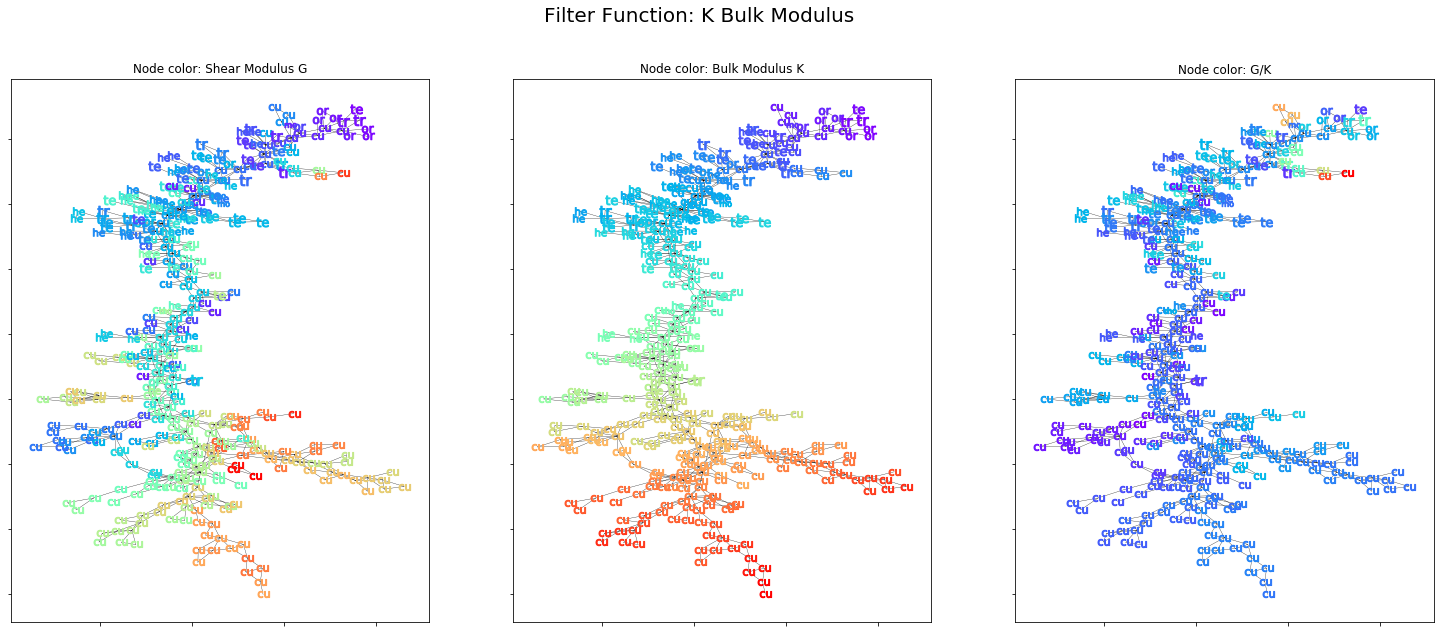

In [102]:
# Figure for xtal systems
cm1 = plt.cm.get_cmap('rainbow')
fig1xtal = plt.figure(figsize=(25.5,10))
ax1 = fig1xtal.add_subplot(1,3,1)
ax2 = fig1xtal.add_subplot(1,3,2)
ax3 = fig1xtal.add_subplot(1,3,3)
axall = [ax1, ax2, ax3]

for ed in edg_ls:
    ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax2.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax3.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax_c = axall[subplt-1]
    for xxyy, cnd_xtal, ndclr in zip(nd_plt, nd_xtal_ls, nd_clr[clr_ppt]):
        xtal_cntr = Counter(cnd_xtal)
        mk_xtal = max(xtal_cntr, key=xtal_cntr.get)
    #     if xtal_cntr.get(mk_xtal) >= len() # use when for at least of half of the materials are the same
                                             # crystal system.
        ax_c.scatter(xxyy[0], xxyy[1], marker= '$\mathrm{'+mk_xtal[:2]+'}$',
                   zorder=2,
                     c = cm1((ndclr-min(nd_clr[clr_ppt]))/(max(nd_clr[clr_ppt])-min(nd_clr[clr_ppt]))),
                     s=150)
    ax_c.set_title(f'Node color: {clr_title[subplt-1]}')
    ax_c.set_xticklabels([])
    ax_c.set_yticklabels([])
fig1xtal.suptitle('Filter Function: K Bulk Modulus', fontsize=20)

In [103]:
fig1xtal.savefig('./results/figs/flt_bulk_GKGk_xtal.png', bbox_ineches='tight', dpi=300)

## Filter function: G/K

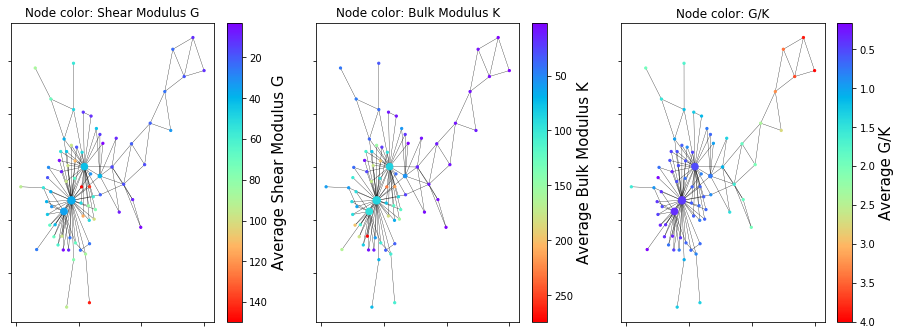

In [104]:
# read simplicial complex
with open('./results/simp_comp3GK.json', 'r') as fp:
    smp_cmp_dic = json.load(fp)

# set colormap
cm1 = plt.cm.get_cmap('rainbow')
# select number of filter function intervals and the corresponding simp.comp.
n_cub = 90
simplicial_complex = smp_cmp_dic[f'smpcmp_ncub{n_cub}']

# dics to store the values which determine the color of the node for all nodes.
# the color can be G, K and G/K.
node_c_dicK = {}
node_c_dicG = {}
node_c_dicGK = {}
# the crystal types of the compounds in every nodes as well.
node_xtal_dic = {}
# iterate through all nodes
for ii, tt in dict(simplicial_complex["nodes"]).items():
    # average is used
    node_c_dicK[ii] = np.average([K_ls[kk] for kk in tt])
    node_c_dicG[ii] = np.average([G_ls[kk] for kk in tt])
    node_c_dicGK[ii] = np.average([GK_ls[kk] for kk in tt])
    node_xtal_dic[ii] = [xtal_c[kk] for kk in tt]

# nodes and edges     
nodes = simplicial_complex["nodes"].keys()
edges = [[start, end] for start, ends in simplicial_complex["links"].items() for end in ends]
# new graph, with adding nodes and nodes properties.
g = nx.Graph()
g.add_nodes_from(nodes)
nx.set_node_attributes(g, dict(simplicial_complex["nodes"]), "membership")
# setting attributes to nodes
nx.set_node_attributes(g, node_c_dicG, "node_clrG")
nx.set_node_attributes(g, node_c_dicK, "node_clrK")
nx.set_node_attributes(g, node_c_dicGK, "node_clrGK")
# add edges to graph
g.add_edges_from(edges)
# get the largest connected components for plotting.
# This is optional, but if there are more than one connected components
# in the mapper output, the layout can have overlap.
largest_cc = max(nx.connected_components(g), key=len)

# below are the lists/dics for plotting,
# only plot the largest connected component.
nd_plt = [] # list of nodes coordinates
nd_plt_d = {} # dic of nodes coordinates
nd_clr = {'G':[], 'K':[], 'GK':[]} # values of nodes for coloring
edg_ls = [] # edge list for plotting
ndsz_ls = [] # node size, length of the member lists
nd_cmpd_ls = [] # nodes compounds list, store the compounds in every nodes
nd_nbr_ls = [] # nodes neighbors list, store the neighbors of every nodes in the largest c.c.
mktp = ['$\mathrm{C}$', '$\mathrm{O}$', '$\mathrm{T}$'] # markers in scatter plot

# since we only show the largest connected component in the plot,
# need to test if the node is belonging to the largest c.c.
for ed in g.edges:
    if ed[0] in largest_cc or ed[1] in largest_cc:
        edg_ls.append(ed)

nd_cntr_ls = [] # counter for nodes indices
# the nodes from mapper output are indexed as strings,
# need this to convert to number so can be easily read in excel files.
nd_xtal_ls = [] # list for storing crystal systems of the nodes that are in the largest c.c.

# select a layout method
for nd, pos in nx.kamada_kawai_layout(g).items():
# for nd, pos in nx.spring_layout(g).items():
# for nd, pos in nx.spectral_layout(g).items():
    if nd in largest_cc:
        nd_cntr_ls.append(nd) # append the current node to list
        nd_plt.append([pos[0], pos[1]])
        nd_plt_d[nd] = pos
        nd_clr['G'].append(g.nodes[nd]['node_clrG'])
        nd_clr['K'].append(g.nodes[nd]['node_clrK'])
        nd_clr['GK'].append(g.nodes[nd]['node_clrGK'])
        ndsz_ls.append(len(g.nodes[nd]['membership']))
        nd_cmpd_ls.append([formula[jj] for jj in g.nodes[nd]['membership']])
        nd_xtal_ls.append(node_xtal_dic[nd])
for nd in nd_cntr_ls:
    nd_nbr_ls.append([nd_cntr_ls.index(nnbb) for nnbb in g.neighbors(nd)])


        
flt_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
clr_title = ['Shear Modulus G', 'Bulk Modulus K', 'G/K']
# Figure
fig1 = plt.figure(figsize=(15.5,5.5))
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax1 = fig1.add_subplot(1,3,subplt)
    for ed in edg_ls:
        ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
            c='k', linewidth=.3, zorder=1)
    sc = ax1.scatter(*np.array(nd_plt).T, 
                     c=nd_clr[clr_ppt],
                     s= 50*np.array(ndsz_ls)/max(ndsz_ls)+5,
                     zorder=2, edgecolor=None, cmap=cm1)
    cbar = fig1.colorbar(mappable=sc, ax=ax1)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'Average {clr_title[subplt-1]}', fontsize=15)
    ax1.set_title(f'Node color: {clr_title[subplt-1]}')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

# fig1.suptitle('Filter Function: K Bulk Modulus', fontsize=20)
# fig1.suptitle('Filter Function: G Shear Modulus', fontsize=20)
# fig1.suptitle('Filter Function: G/K (Ductility)', fontsize=20)

In [105]:
fig1.savefig('./results/figs/flt_duc_GKGk.png', bbox_ineches='tight', dpi=300)

In [106]:
pd.DataFrame(nd_cmpd_ls).to_excel('./results/cmp_flt_ducGK.xlsx')
pd.DataFrame(nd_nbr_ls).to_excel('./results/nbr_flt_ducGK.xlsx')

Text(0.5,0.98,'Filter Function: G/K Ductility')

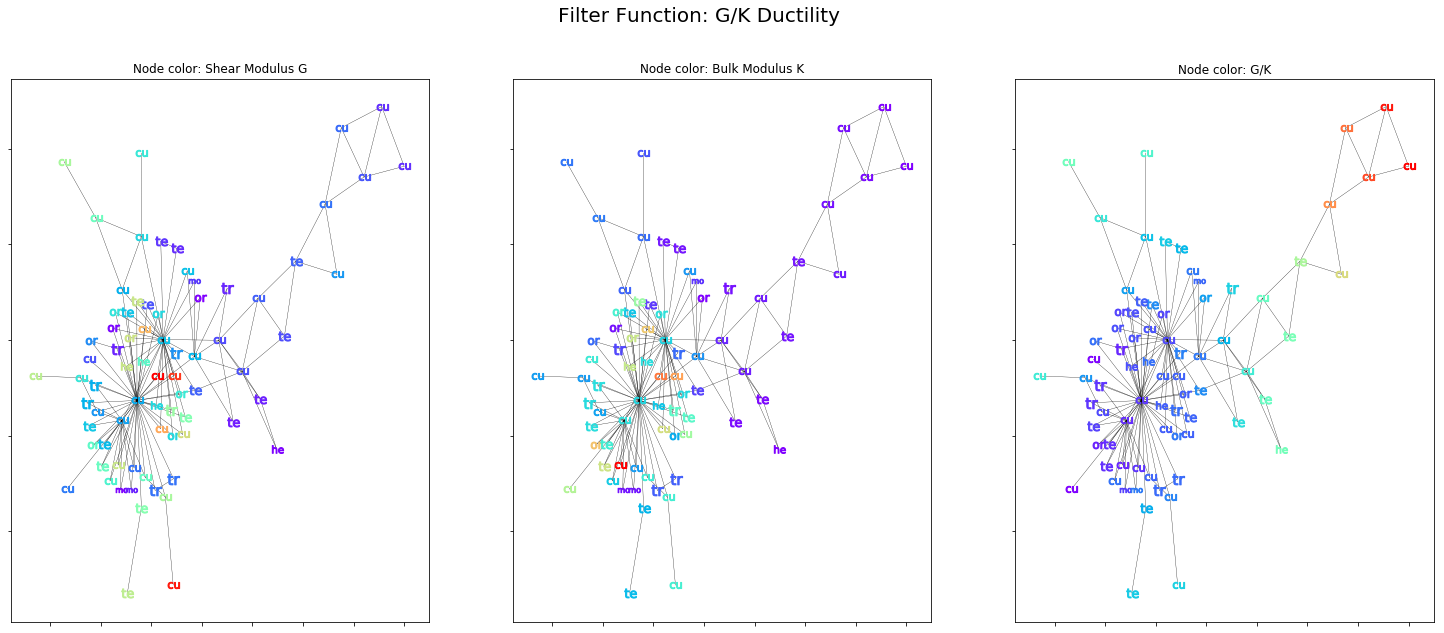

In [107]:
# Figure for xtal systems
cm1 = plt.cm.get_cmap('rainbow')
fig1xtal = plt.figure(figsize=(25.5,10))
ax1 = fig1xtal.add_subplot(1,3,1)
ax2 = fig1xtal.add_subplot(1,3,2)
ax3 = fig1xtal.add_subplot(1,3,3)
axall = [ax1, ax2, ax3]

for ed in edg_ls:
    ax1.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax2.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    ax3.plot([nd_plt_d[ed[0]][0], nd_plt_d[ed[1]][0]], [nd_plt_d[ed[0]][1], nd_plt_d[ed[1]][1]],
             c='k', linewidth=.3, zorder=1)
    
for subplt, clr_ppt in zip(range(1,4), ['G', 'K', 'GK']):
    ax_c = axall[subplt-1]
    for xxyy, cnd_xtal, ndclr in zip(nd_plt, nd_xtal_ls, nd_clr[clr_ppt]):
        xtal_cntr = Counter(cnd_xtal)
        mk_xtal = max(xtal_cntr, key=xtal_cntr.get)
    #     if xtal_cntr.get(mk_xtal) >= len() # use when for at least of half of the materials are the same
                                             # crystal system.
        ax_c.scatter(xxyy[0], xxyy[1], marker= '$\mathrm{'+mk_xtal[:2]+'}$',
                   zorder=2,
                     c = cm1((ndclr-min(nd_clr[clr_ppt]))/(max(nd_clr[clr_ppt])-min(nd_clr[clr_ppt]))),
                     s=150)
    ax_c.set_title(f'Node color: {clr_title[subplt-1]}')
    ax_c.set_xticklabels([])
    ax_c.set_yticklabels([])
fig1xtal.suptitle('Filter Function: G/K Ductility', fontsize=20)

In [108]:
fig1xtal.savefig('./results/figs/flt_duc_GKGk_xtal.png', bbox_ineches='tight', dpi=300)